# Camera Callibration, Undistortion and Perspective Transformation

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt
import pickle
%matplotlib inline

# Callibrating the Camera

In [2]:
# number of horrizontal and vertical corners in the callibration chessboard
nx, ny = (8, 6)
# Callibrate Camera Function
def callibrate_camera(callibration_images):
    
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(callibration_images):
        # Load Image
        img = cv2.imread(fname)
        # Convert to GRAY
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (8,6), corners, ret)
            # Save and show Images
            #write_name = 'corners_found'+str(idx)+'.jpg'
            #cv2.imwrite(write_name, img)
            #cv2.imshow('img', img)
            #cv2.waitKey(500)
            #cv2.destroyAllWindows()

    
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    return mtx, dist

# Undistort Image Function
def undistort_image(image, mtx, dist):
    undistorted = cv2.undistort(image, mtx, dist, None, mtx)
    return undistorted

In [3]:
# Make a list of calibration images
callibration_images = glob.glob('calibration_wide/GO*.jpg')
#print(images)

In [4]:
# Callibrating the Camera
print("Callibrating.......")
#mtx, dist = callibrate_camera(callibration_images)
print("Callibration complete!")
# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration_wide/wide_dist_pickle.p", "wb" ) )


Callibrating.......
Callibration complete!


In [5]:
# Test undistortion on an image
img = cv2.imread('test_image2.png')
undistorted_img = undistort_image(img, mtx, dist)
# Converting to RGB
#undistorted_img = cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2RGB)

Text(0.5, 1.0, 'Undistorted Image')

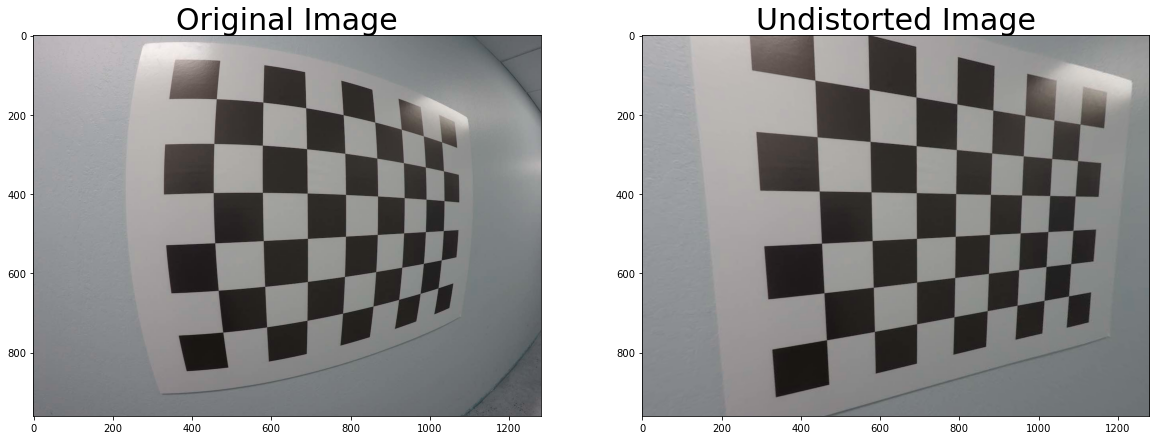

In [6]:
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted_img)
ax2.set_title('Undistorted Image', fontsize=30)

# Perspective Transformation and Warping

In [11]:
# Warping the Undistorted Image
def corners_unwarp(undistorted_img, nx, ny, mtx, dist):    
    gray  = cv2.cvtColor(undistorted_img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    print(type(corners))
    print(corners)
    if ret:
        # If we want to draw chessboard corners: uncomment the below line
        #cornerImg = cv2.drawChessboardCorners(undistorted_img, (nx,ny), corners, ret)
        src = np.float32([corners[0], corners[nx - 1],  corners[nx*ny -1], corners[(nx*ny) - nx]])
        #print(src)
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        print("dst")
        print(type(dst))
        # Compute the perspective transform, M, given source and destination points:
        M = cv2.getPerspectiveTransform(src, dst)
        warped = cv2.warpPerspective(undistorted_img, M, img_size, flags=cv2.INTER_LINEAR)

    return warped, M


In [12]:
# Load an Image
img = cv2.imread('test_image2.png')
# Undistort it
undistorted_img = undistort_image(img, mtx, dist)
top_down, perspective_M = corners_unwarp(undistorted_img, nx, ny, mtx, dist)

<class 'numpy.ndarray'>
[[[ 436.469     114.307686]]

 [[ 573.60223   137.86833 ]]

 [[ 691.4122    156.33318 ]]

 [[ 793.9395    174.458   ]]

 [[ 884.1251    190.41093 ]]

 [[ 966.13055   203.39478 ]]

 [[1037.9377    215.65773 ]]

 [[1103.9918    224.65347 ]]

 [[ 441.40646   256.57117 ]]

 [[ 575.6237    268.4834  ]]

 [[ 691.44507   279.54266 ]]

 [[ 792.4461    289.64633 ]]

 [[ 881.6096    297.70975 ]]

 [[ 962.30566   304.28372 ]]

 [[1033.0293    311.57455 ]]

 [[1098.5       317.5     ]]

 [[ 447.05347   393.79935 ]]

 [[ 577.4161    395.537   ]]

 [[ 692.3993    397.60666 ]]

 [[ 791.14557   400.2638  ]]

 [[ 878.7047    401.7645  ]]

 [[ 956.86456   403.5924  ]]

 [[1026.5771    405.1308  ]]

 [[1092.2926    407.16342 ]]

 [[ 453.26105   525.3415  ]]

 [[ 580.83246   518.7387  ]]

 [[ 692.3153    513.1387  ]]

 [[ 790.28625   507.55692 ]]

 [[ 875.6145    502.70306 ]]

 [[ 953.82733   499.39743 ]]

 [[1023.0655    495.02853 ]]

 [[1086.        493.5     ]]

 [[ 459.2187    

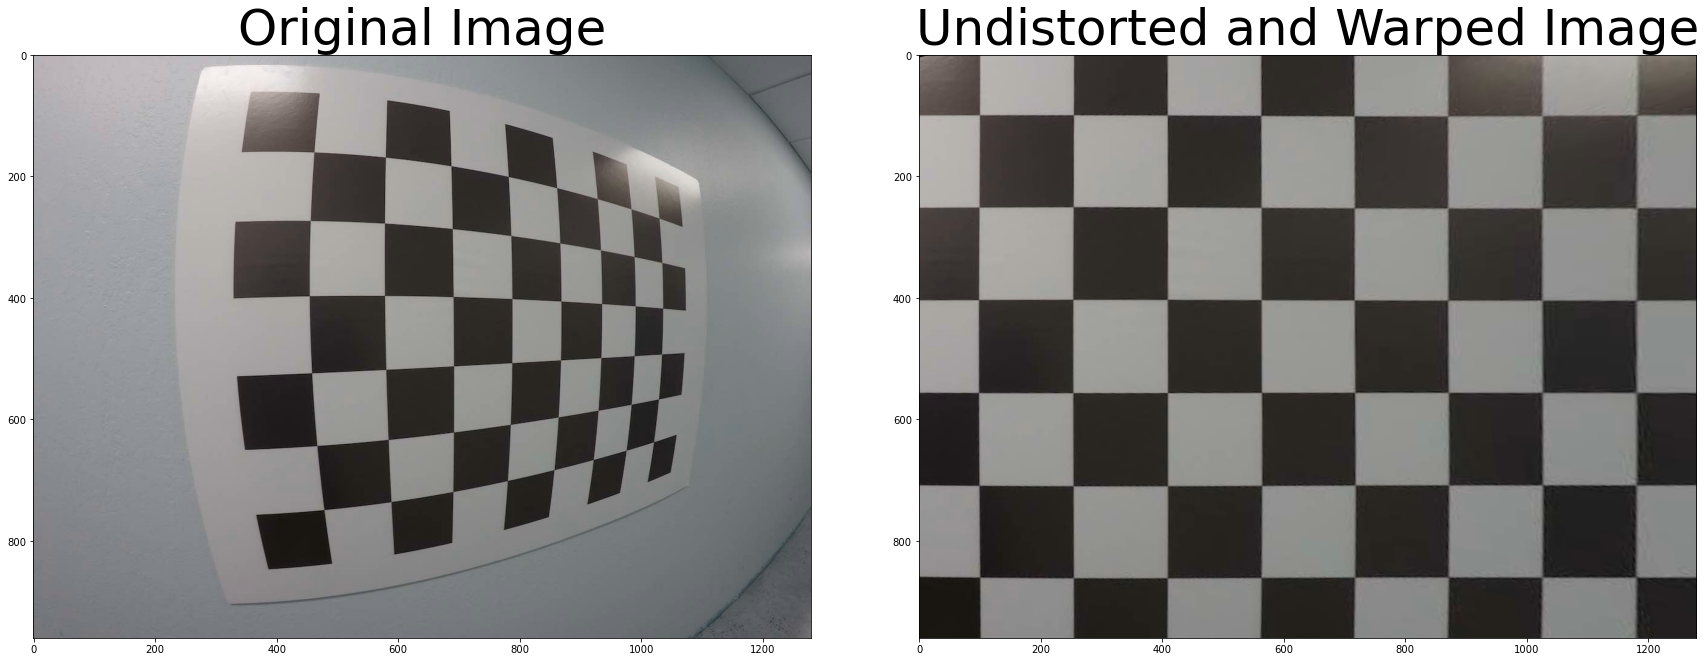

In [48]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)